# My Approach to Tabular May 2022 Competition

Hi, in this notebook I have performed EDA, plotted all possibilities of feature relations and used SHAP to find the most impactul and useless features in this data to help us in making better predictions.

I hope the interactions will provide some useful insights to score even higher in this competition.

**Please upvote if you like it!**

# Table of Contents
* [Importing Libraries](#section-one)
* [Reading the data files](#section-two)
* [Overview](#section-three)
* [Exploratory Data Analysis (EDA)](#section-four)
    - [Scaling](#subsection-fourone)
    - [Correlation Check](#subsection-fourtwo)
    - [Outlier Treatment](#subsection-fourthree)
* [Feature Engineering](#subsection-five1)
* [Exploring non-linear feature interactions](#subsection-five2)
* [Modeling](#section-six)
* [Model Explainability using SHAP](#section-seven)

<a id="section-one"></a>
# Importing Libraries

In [ ]:
#Importing Required Libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import shap

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import roc_curve, auc, roc_auc_score
from statistics import mean

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
sns.set_palette("coolwarm_r")

<a id="section-two"></a>
# Reading the data files

In [ ]:
#Reading the data files

train = pd.read_csv('../input/tabular-playground-series-may-2022/train.csv')
test = pd.read_csv('../input/tabular-playground-series-may-2022/test.csv')
sample = pd.read_csv('../input/tabular-playground-series-may-2022/sample_submission.csv')

<a id="section-three"></a>
# Overview

In [ ]:
print(f'Shape of train data: {train.shape}')
print(f'Missing values count: {train.isna().sum().sum()}')

train.head()

In [ ]:
train.info()
print ("*"*40)
train.nunique()

* Training data has 900000 records and 33 features. 
* Column 'id' is the primary key.
* It's a binary classification problem and 'target' is our target variable.
* All the features are numerical except f_27.
* There is no missing value in the data.
* Features f_07 till f_18 and f_29, f_30 are discrete numerical features, rest all are continuous features.

In [ ]:
print(f'Shape of test data: {test.shape}')
print(f'Missing values count: {test.isna().sum().sum()}')

test.head()

In [ ]:
test.info()
print ("*"*40)
test.nunique()

* Training data has 700000 records and 32 features. 
* Column 'id' is the primary key.
* All the features are numerical except f_27.
* There is no missing value in the data.
* Features f_07 till f_18 and f_29, f_30 are discrete numerical features, rest all are continuous features.

In [ ]:
sample.head()

* We need to submit the predicted probability values for each id in the test data.

<a id="section-four"></a>
# Exploratory Data Analysis (EDA)

In [ ]:
# Setting 'id' as index
train = train.set_index('id')
test = test.set_index('id')

In [ ]:
#Checking if there is any difference between the behaviour of train and test data
train.describe() - test.describe()

There is not a major difference in the values of all features of test and train data. This is a good sign and will help us in correct model validation.

In [ ]:
num_columns = train.select_dtypes(exclude=['object']).columns
num_columns = [i for i in num_columns if i != 'target']

cat_columns = train.select_dtypes(include=['object']).columns

In [ ]:
train.describe().T.style.bar(subset=['mean'], color='royalblue')\
                            .background_gradient(subset=['std'], cmap='coolwarm_r')\
                            .background_gradient(subset=['50%'], cmap='coolwarm_r')\
                            .background_gradient(subset=['min'], cmap='coolwarm_r')\
                            .background_gradient(subset=['max'], cmap='coolwarm_r')

**Observations**

* All the features are in small scale except feature f_28. We will need to scale down these features before fitting the model.
* It will be wise to keep an eye on this feature f_28 because of its different scale.

#### Analyzing Target Feature

In [ ]:
#Checking the distribution of target variable

target1 = train['target'].value_counts()[1]
target0 = train['target'].value_counts()[0]
target1per = target1 / train.shape[0] * 100
target0per = target0 / train.shape[0] * 100

print('{} of {} records have target 1 it is the {:.2f}% of the training set.'.format(target0, train.shape[0], target0per))
print('{} of {} records have target 2 and it is the {:.2f}% of the training set.'.format(target1, train.shape[0], target1per))

plt.figure(figsize=(8,6))
sns.countplot(train['target'], palette = 'coolwarm_r', order = sorted(train['target'].unique()))

plt.xlabel('Target', size=12, labelpad=15)
plt.ylabel('Count', size=12, labelpad=15)
plt.xticks((0, 1), ['1 ({0:.2f}%)'.format(target0per), '2 ({0:.2f}%)'.format(target1per)])
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.title('Training Set Target Distribution', size=15, y=1.05)

plt.show()

**Observations**

* The distribution of the classes are balanced.
* Class 1 is having 3% more records than class 0.

#### Analyzing Continuous Features

In [ ]:
len(num_columns)

All of the 50 features are numerical in this data.

In [ ]:
# # Checking the distribution of continuous features
# from tqdm import tqdm

# i = 1
# fig, ax = plt.subplots(6,5, figsize=(40,30))

# for feature in tqdm(num_columns):
#     plt.subplot(6,5, i)
#     sns.kdeplot(data = train, y = feature, vertical=True, palette = 'coolwarm_r', shade = True)
#     plt.xlabel(f'{feature}- Skew: {round(train[feature].skew(), 2)}', size=20)
#     i += 1

# fig.tight_layout()
# plt.show()

**Observation**

* The numerical features do not have large skewness and most features follow normal distribution. 

Let's create a countplot on the discrete numerical features.

In [ ]:
x = train.nunique()
num_cat_features = x[x<1000].index
num_cat_features = [i for i in num_cat_features if i != 'target']

In [ ]:
len(num_cat_features)

In [ ]:
# Checking the distribution of discrete continuous features
from tqdm import tqdm

i = 1
fig, ax = plt.subplots(5,3, figsize=(50,30))

for feature in tqdm(num_cat_features):
    plt.subplot(5,3, i)
    sns.countplot(data = train, x = feature, order = train[feature].value_counts().index, hue = 'target', palette = 'coolwarm_r')
    plt.xlabel(feature, size=25)
    plt.legend(loc='upper right', prop={'size': 15})
    i += 1

fig.delaxes(ax[4,2])
fig.tight_layout()
plt.show()

**Observations**

* None of the values show significant difference between the two classes.
* In features f_07 till f_18, count reduces drastically after few values.

<a id="subsection-fourtwo"></a>
## Correlation Check

In [ ]:
num_columns = train.select_dtypes(exclude=['object']).columns
num_columns = [i for i in num_columns if i != 'target']

cat_columns = train.select_dtypes(include=['object']).columns

In [ ]:
#Let's check how the features are linearly inter-related to each other and with target variable
sns.set(font_scale=3)
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(60,60))
ax.set_title("Correlation Matrix", fontsize=30)

corr = train[num_columns + ['target']].corr().abs()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm_r',
            cbar_kws={"shrink": .8}, vmin=0, vmax=1, annot_kws={"fontsize":25})

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
    tick.label.set_rotation(90) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
    tick.label.set_rotation(0)
    
plt.show()

**Observations**

* None of the features show significant correlation among themselves and with the target variable.

<a id="subsection-fourone"></a>
## Scaling

In [ ]:
train.describe()

**Observations**

* There are some high max values present in this data. Let's get them to a standard scale.

In [ ]:
#Scaling the data using standard scaler

train[num_columns] = StandardScaler().fit_transform(train[num_columns])
test[num_columns] = StandardScaler().fit_transform(test[num_columns])

<a id="subsection-fourthree"></a>
## Outlier Treatment

In [ ]:
# Outlier Analysis

iqr_factor = [3]
list1, list2 = [], []

for factor in iqr_factor:
    count = 0
    print(f'Outliers for {factor} IQR :')
    print('-------------------------------------')
    for col in num_columns:
    
        IQR = train[col].quantile(0.75) - train[col].quantile(0.25)
        lower_lim = train[col].quantile(0.25) - factor*IQR
        upper_lim = train[col].quantile(0.75) + factor*IQR
    
        cond = train[(train[col] < lower_lim) | (train[col] > upper_lim)].shape[0]
        
        if cond > 0 and factor == 1.5:
            list1.append(train[(train[col] < lower_lim) | (train[col] > upper_lim)].index.tolist())
        elif cond > 0 and factor == 3:
            list2.append(train[(train[col] < lower_lim) | (train[col] > upper_lim)].index.tolist())
        
        if cond > 0: print(f'{col:<30} : ', cond); count += cond
    print(f'\nTOTAL OUTLIERS FOR {factor} IQR : {count}')
    print('')

**Observations**

* The above table shows the number of outliers in each feature. 
* The high outlier number in discrete continuous features are not the actual outliers. It is due to the discrete distribution of the data.
* Let's keep these small number of outliers as they are.

<a id="subsection-five1"></a>
# Feature Engineering

Let's transform the only categorical feature 'f_27' by creating separate feature for each digit and an additional feature containing the number of unique characters.

In [ ]:
# Credits to https://www.kaggle.com/code/ambrosm/tpsmay22-keras-quickstart/notebook
for df in [train, test]:
    for i in range(10):
        df[f'ch{i}'] = df.f_27.str.get(i).apply(ord) - ord('A')
    # Next feature is from https://www.kaggle.com/code/cabaxiom/tps-may-22-eda-lgbm-model
    df["unique_characters"] = df.f_27.apply(lambda s: len(set(s)))
    # Get Unique letters string
    df["unique_text_str"] = df["f_27"].apply(lambda x :  ''.join([str(n) for n in list(set(x))]) )
    df["unique_text_str"] = df["unique_text_str"].astype("category")
    df.drop('f_27', axis=1, inplace=True)    
print("Columns: \n{0}".format(list(train.columns)))
train.head()

In [ ]:
#exploring the killer feature in this dataset

sns.set(font_scale=1)
train_sample = train.sample(n=500000)
train_sample = train_sample.reset_index(drop = True)

sns.scatterplot(train_sample['f_02'], train_sample['f_21'], hue = train_sample['target'], s = 3)

<a id="subsection-five2"></a>
# Exploring non-linear dependence among features

In [ ]:
num_columns = train.select_dtypes(exclude=['object', 'category']).columns
num_columns = [i for i in num_columns if i != 'target']

cat_columns = train.select_dtypes(include=['object', 'category']).columns

In [ ]:
len(num_columns)

In [ ]:
#Source: https://www.kaggle.com/code/ambrosm/tpsmay22-eda-which-makes-sense

# Plot dependence between every feature and the target

sns.set(font_scale=1)
train_sample = train.sample(n=100000)
train_sample = train_sample.reset_index(drop = True)

for i in num_columns:
    num_columns1 = [x for x in num_columns if x != i]
    fig, axs = plt.subplots(4,10, figsize=(24,8))
    for f, ax in zip(num_columns1, axs.ravel()):
        temp = pd.DataFrame({f: train_sample[f].values,
                             'state': train_sample[i].values, 'target': train_sample['target'].values})
        temp = temp.sort_values(f)
        temp.reset_index(inplace=True)
        temp0 = temp[temp['target'] == 0]
        temp1 = temp[temp['target'] == 1]
        ax.scatter(temp0[f], temp0.state.rolling(15000, center=True).mean(), s=2, color = 'royalblue')
        ax.scatter(temp1[f], temp1.state.rolling(15000, center=True).mean(), s=2, color = 'darkred')
        ax.set_xlabel(f'{f}')
        ax.set_ylabel(f'{i}')
    plt.suptitle(f'How feature {i} depends on other features            Legend: Red line- Target 1, Blue line- Target 0', fontweight='bold')
    plt.tight_layout()
    plt.show()

**Observations**

* Now we know why the model are giving very high AUC scores. There is a clear separation between many features and target variable. (red and blue lines)
* There are many plots where two features are showing some linear and non linear relationships.
* The 'ch' features are clearly separating the classes. These features should improve the model score significantly.
* Features 03, 04, 06, 07, 12, 17, 18 are not separating the classes clearly. I doubt if these features are providing any value to the model.
* There are interesting line patterns visible in features 19 till 30.

We can experiment with the above relationships by creating many interaction variables which can boost up the AUC.

<a id="section-six"></a>
# Modeling

Let's train a simple LGBM model with 5 fold cross validation.

In [ ]:
train = train.reset_index(drop = True)

In [ ]:
# Storing the target variable separately

X_train = train.drop('target', axis = 1)
X_test = test
y_train = train['target']

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))

In [ ]:
#Stratified K fold split Cross Validation

def train_and_validate(model, N):
    
    regex = '^[^\(]+'
    match = re.findall(regex, str(model))
    print(f'Running {N} Fold CV with {match[0]} Model.')
    
    probs = pd.DataFrame(np.zeros((len(X_test), N * 2)), columns=['Fold_{}_Prob_{}'.format(i, j) for i in range(1, N + 1) for j in range(2)])
    importances = pd.DataFrame(np.zeros((X_train.shape[1], N)), columns=['Fold_{}'.format(i) for i in range(1, N + 1)], index=train.drop('target', axis = 1).columns)
    fprs, tprs, scores = [], [], []

    skf = StratifiedKFold(n_splits=N, random_state=N, shuffle=True)

    for fold, (trn_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
        print('Fold {}\n'.format(fold))
        
        # Fitting the model
        model.fit(X_train.iloc[trn_idx], y_train[trn_idx])

        # Computing Train AUC score
        trn_fpr, trn_tpr, trn_thresholds = roc_curve(y_train[trn_idx], model.predict_proba(X_train.iloc[trn_idx])[:, 1])
        trn_auc_score = auc(trn_fpr, trn_tpr)
        # Computing Validation AUC score
        val_fpr, val_tpr, val_thresholds = roc_curve(y_train[val_idx], model.predict_proba(X_train.iloc[val_idx])[:, 1])
        val_auc_score = auc(val_fpr, val_tpr)  

        scores.append((trn_auc_score, val_auc_score))
        fprs.append(val_fpr)
        tprs.append(val_tpr)

        # X_test probabilities
        probs.loc[:, 'Fold_{}_Prob_0'.format(fold)] = model.predict_proba(X_test)[:, 0]
        probs.loc[:, 'Fold_{}_Prob_1'.format(fold)] = model.predict_proba(X_test)[:, 1]
        importances.iloc[:, fold - 1] = model.feature_importances_
        
        print(scores[-1])    
    
    trauc = mean([i[0] for i in scores])
    cvauc = mean([i[1] for i in scores])
    print(f'Average Training AUC: {trauc}, Average CV AUC: {cvauc}')
    print ("*"*40)
    print ("\n")
    
    return trauc, cvauc, importances, probs, model

In [ ]:
#Testing multiple ML models using stratified K fold CV

df_row = []
N = 3

for i in [
    #DecisionTreeClassifier(),
    LGBMClassifier()]:
#     RandomForestClassifier(n_estimators = 10, max_depth = 30),
#     XGBClassifier(verbosity = 0)]:
    
    trauc, cvauc, importances, probs, model = train_and_validate(i, N)
    
    regex = '^[^\(]+'
    match = re.findall(regex, str(i))
    
    df_row.append([match[0], trauc, cvauc])

df = pd.DataFrame(df_row, columns = ['Model', f'{N} Fold Training AUC', f'{N} Fold CV AUC'])
df

**Observations**

* LGBM Model is fitting well with CV AUC 0.955. 
* Also, this model is not overfitting since the difference between train and CV AUC is not large.
* But Neural Network models can perform well on this data since the number of records are very large.

In [ ]:
#Plotting the RandomForest importances

importances['Mean_Importance'] = importances.mean(axis=1)
importances.sort_values(by='Mean_Importance', inplace=True, ascending=False)

plt.figure(figsize=(8,8))
sns.barplot(x='Mean_Importance', y=importances.head(15).index, data=importances.head(15), palette = 'coolwarm_r')

plt.xlabel('')
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)
plt.title('Top 15 features', size=10)

plt.show()

**Observations**

* As expected from EDA, ch features and unique character features are among the top important features.
* It's interesting to see feature f_26, f_21, f_30 appearing at the top of importance list. Let's explore more about these features using SHAP. These important features do show some interesting patterns in the inter dependence charts above.

Let's try making a submission with LGBM model and see the performance on leaderboard.

In [ ]:
#Creating the submission
cols = [i for i in probs.columns if i.endswith('1')]

probs = probs[cols]

sample['target'] = probs.sum(axis = 1)/5
sample.to_csv('submission.csv', index = False)

Great! LGBM scored a auc of 1.088 which is an improvement over the Random Forest Model.

Let's try to understand more about the features behaviour using SHAP.

<a id="section-seven"></a>
# Model Explainability using SHAP

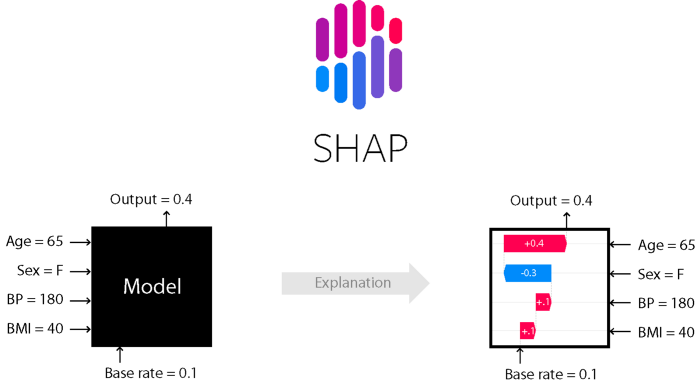

In [ ]:
X_train = X_train.sample(n=200000)

In [ ]:
#Fitting the SHAP on our model and training data

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

In [ ]:
#Plotting the SHAP summary. (Note: Class 0 in the analysis below correspond to class 1 in the data and so on.)

shap.summary_plot(shap_values, X_train, color=plt.get_cmap("tab20c"))

**Observations**

* SHAP also confirms the usefulness of the 'ch' and unique character feature.
* But a single feature alone cannot be used to predict any class since the bar length for both classes are almost same.
* There is a big play of feature interactions in this data!!
* Features f_26, f_29, and f_30 are coming on top in this chart as well. There is surely some hidden information present in these features.

In [ ]:
shap.summary_plot(shap_values[1], X_train, show = False, cmap = 'coolwarm_r')
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)

**Observations**

* Class 1 have low ASCII characters in the first letter of f_27 feature.
* Number of unique characters should be as high as possible for class 1.
* Higher values in f_26, f_29, f_21 is helping model in predicting class 1.
* There is a clear red and blue line sepatation in f_26, f_29, f_21 numerical features which is making them the most important feature.

##  Most useless features in this data

As per the above analysis, it seems like features f_03, f_04, f_06, f_07, f_12, f_17, f_18 are not having a big impact on the model precition.

We can experiment by removing these features and rerun the analysis.

# The End!

Thank you for reading this notebook. I hope that you have learned something new with this analysis.
Please share feedback if you find any flaw or have a better approach.

### Please upvote if you liked. It will motivate me to do better :)
![](http://68.media.tumblr.com/e1aed171ded2bd78cc8dc0e73b594eaf/tumblr_o17frv0cdu1u9u459o1_500.gif)